# Looking Predictive Model

En este cuaderno se tratara de buscar el mejor modelo de aprendizaje supervisado para tratar de predecir el porcentaje de que una canción sea hit o no, acorde a las caracteristicas que hemos obtenido.

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import joblib
plt.rcParams['figure.figsize'] = 8, 6

- Definimos función que usaremos para extraer las caracteristicas necesarias de una canción para hacer una predicción de probabilidad de ser un *hit* una vez entrenado el modelo.

In [3]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id='01ec25b32db847e3aeb622ebe1a894c8', client_secret='cd8d3b7666164ea5943688215d9226c2') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=50)

def find_song():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        track_feat = sp.audio_features(id_track)
        song = [[track_feat[0]["danceability"], track_feat[0]["energy"], track_feat[0]["key"],
        track_feat[0]["loudness"], track_feat[0]["mode"], track_feat[0]["speechiness"],
        track_feat[0]["acousticness"], track_feat[0]["instrumentalness"], track_feat[0]["liveness"],
        track_feat[0]["valence"], track_feat[0]["tempo"],track_feat[0]["time_signature"],
                track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Se lee dataframe y se realiza *split* para los entrenamientos y test.

In [4]:
df_songs = pd.read_csv("../Data/fusion_songs_1993_2020_to_train.csv")

In [5]:
df_songs.head()

,artist,title,id,year_chart,date_chart,release_date,collaboration,rank,weeks,isNew,peakPos,lastPos,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,popularity_artist,popularity_song,genres,album,label,song_lyrics,target
0,PARTYNEXTDOOR,Come and See Me (feat. Drake),1wZqJM5FGDEl3FjHDxDyQd,2016.0,2016-12-31,2016-08-12,True,63.0,24.0,False,55.0,56.0,0.717,0.347,11,-10.265,0,0.0636,0.0511,0.000002,0.087,0.0589,84.987,4,235477,83,73,"['pop', 'pop rap', 'rap', 'toronto rap', 'trap...",PARTYNEXTDOOR 3 (P3),OVO Sound/Warner Records,Usually hear the phone late night like now\nSh...,1
1,Macy Todd,I've Got a Feelin',2xnIFEOXHXlzIyJN0itwBX,NaN,NaN,2016-07-15,False,NaN,NaN,NaN,NaN,NaN,0.475,0.546,10,-7.140,0,0.0399,0.3570,0.000056,0.330,0.4930,183.895,3,220533,27,0,[],I've Got a Feelin',Macy Todd Music,NaN,0
2,The Japanese House,You Seemed so Happy,0NuIfPuBhUAt4aA4HP0rUu,NaN,NaN,2019-03-01,False,NaN,NaN,NaN,NaN,NaN,0.519,0.888,11,-6.232,1,0.1170,0.0406,0.000000,0.227,0.4160,149.938,4,162485,63,52,"['art pop', 'electropop', 'indie pop', 'indie ...",Good At Falling,Dirty Hit/The Japanese House PS,NaN,0
3,Krzysztof Komeda,Rosemary's Baby Main Theme Vocal,28D0Hfi6x9zAeGr1sDYBkb,NaN,NaN,2008-07-21,False,NaN,NaN,NaN,NaN,NaN,0.265,0.255,3,-11.284,1,0.0358,0.8410,0.138000,0.247,0.1100,116.572,3,152866,32,33,['polish jazz'],Rosemary's Baby,Harkit Records,NaN,0
4,Flyte,White Roses,5xxHfQuaXGEBHtsGbSXwI7,NaN,NaN,2019-07-05,True,NaN,NaN,NaN,NaN,NaN,0.530,0.633,10,-7.078,1,0.0283,0.3910,0.015200,0.142,0.6050,140.186,4,206445,46,53,['english indie rock'],White Roses,Universal-Island Records Ltd.,NaN,0


In [5]:
X = df_songs.loc[:,"danceability":"duration_ms"]
y = df_songs.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Atendiendo a las caracteristicas del dataset, y dado el tipo de problema, vemos con bastante posibilidades de una buena predicción al uso de algoritmos random forest, a partir de este iremos utilizando cada vez modelos mas avanzados para analizar si se consiguen unas mejores predicciones.

## Random Forest

- Como se ha explicado, el primer modelo que usaremos de aprendizaje automatico, será *random forest*

In [11]:
from sklearn.ensemble import RandomForestClassifier

- Probamos el modelo de *random forest* con la configuración por defecto dada por *sklearn*

In [7]:
forest = RandomForestClassifier ()

In [8]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 12.3 s


0.7599378464693165

Vemos el *score* obtenido utilizando *cross validation* ya que sin usar esta tecnica, los modelos basados en arboles de decisión tenderan al sobrenetrenamiento y serán poco generalizables.

La función anterior no almacena el entrenamiento generado, por ello entrenamos el arbol, pero ahora usando todo el dataset para ver los resultados obtenidos con todo el dataset.

In [9]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [10]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7631
Precisión sobre datos de train: 0.9998


Como se ha comentado los modelos basados en arboles de decisión tenderan al sobrenetrenamiento, por lo que la mejor manera es configurarlos utilizando las tecnicas de *cross validation* para que aunque los resultados obtenidos con el entrenamiento den mas bajos, sean modelos mas generalizables.

- El numero de estimadores influencia bastante en la rapidez de entremaniento del modelo, ya que indica el numero de arboles usados en el modelo, pero este valor no debe de ser excesivamente alto para obtener un buen *score*. Para ello calcularemos el *score* para diferentes numeros de estimadores con un *cross val* de 5 que es el que toma por defeccto la función

In [11]:
param_range = [40,50,60,90,100,130,150,200,250,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [12]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 40 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 50 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 60 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 90 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 100 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 130 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 150 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 200 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 250 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 40 en test: 0.7605895033130505 en train: 0.9996090157168964
n_estimators 50 en test: 0.7578520096414392 en train: 0.9997393486770424
n_estimators 60 en test: 0.7599377827874203 en train: 0.999837092425515
n_estimators 90 en test: 0.7639125732474478 en train: 0.9998370910984848
n_estimators 100 en test: 0.7596768143768249 en train: 0.9998370924255152
n_estimators 130 en test: 0.763651541154956 en train: 0.9998533830502605
n_estimators 150 en test: 0.7616973135792092 en train: 0.9998533830502605
n_estimators 200 en test: 0.763651859564437 en train: 0.9998533830502605
n_estimators 250 en test: 0.7641733718396532 en train: 0.9998533830502605
n_estimators 300 en test: 0.7621532335013474 en train: 0.9998533830502605


Tomando el valor medio de cada resultado, ya que por cada prueba obtendremos 5 resultados que son las 5 partes en las que se divide el dataset, segun lo indicado con un *cross val* de 5. Vemos que aumentando el numero de estimadores las mejoras en el modelo son casi imperceptibles, se mantienen casi constante con pequeñas oscilaciones. Por lo que para entrenamientos del modelo no suele ser necesario un uso muy alto del numero de estimadores que lo unico que haran es aumentar el tiempo de entrenamiento.

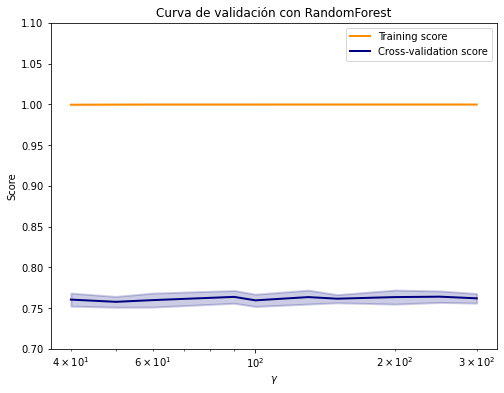

In [13]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.7, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

- A continuación vamos a tratar de mejorar el *score* de nuestro modelo y para ello usaremos la función de RandomizedSearchCV que dado unos rangos en los parametros que indiquemos, ira probando combinaciones aleatorias hasta un numero de pruebas elegido por nosotros. Tambien existe la tecnica de Gridsearch que prueba todas las combinaciones, pero esto haria que el proceso durase varios días, posteriormente usaremos esta tecnica para afinar mas el score, con rangos mas pequeños que son viables en tiempo. Aun así la siguiente prueba ha llevado un total de 456.4 min

In [15]:
forest = RandomForestClassifier (random_state=32)

In [24]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


Seleccionamos para la prueba un *cross val* de 5, definimos random_state, cantidad de mensajes que salga, uso de todas las CPUs disponibles.

In [25]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [26]:
forest_random.fit(X_train, y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   41.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 31.1min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 39.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 57.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 67.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 78.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 90.8min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

- A continuacion se puede ver la mejor configuración encontrada para las iteraciones probadas y el score obtenido para esa configuración.

In [27]:
forest_random.best_params_

{'n_estimators': 110,
 'min_samples_split': 10,
 'min_samples_leaf': 3,
 'max_leaf_nodes': None,
 'max_features': 1,
 'max_depth': 20}

In [29]:
forest_random.best_score_

0.7672357493183383

- La siguente grafica es bastante intersante, ya que muestra la importancia de las caracteristicas respecto de otras, es importante considerar esto ya que las caracteristicas que tengan poca importancia, lo son pero respecto de las otras no quiere decir que su eliminacion del entrenamiento mantenga unos score como hemos obtenido o que mejore el modelo.

In [39]:
best_forest = forest_random.best_estimator_

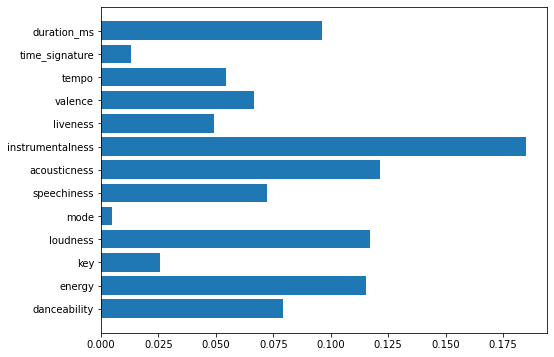

In [40]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_forest.feature_importances_);

- Con la mejor configuración obtenida entrenamos el modelo con todo el dataset de entrenamiento y vemos resultados obtenidos, tantoco con los datos de entrenamiento como test.

In [41]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=1,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=110,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [42]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7662
Precisión sobre datos de train: 0.8829


Podemos ver como el *score* con los datos de entrenamiento, ha decrecido con respecto al modelo inicial, pero en cambio hemos mejorado ligeramente el resultado sobre los resultados de test, en este caso 0.02, que es de lo que se trataba buscar un modelo mas generalizable.

- En este punto almacenaremos nuestro modelo obtenido, para su posterior uso

In [29]:
filename = '../Models/forest_model_random_93_20.pkl'

In [30]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random_93_20.pkl']

In [28]:
best_forest = joblib.load(filename) 

- Por ultimo represntamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

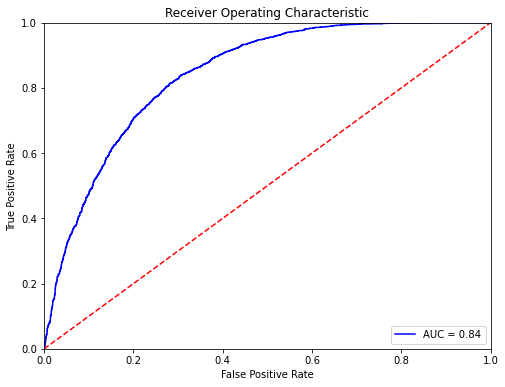

In [43]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [61]:
score = best_forest.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 54.12948614168127


## AdaBoost

-  El segundo modelo que vamos ha utilizar es AdaBoost que utiliza las tecnicas de boosting, un modelo mas avanzado que el anterior del que se espera obtener unos mejores resultados. 

In [6]:
from sklearn.ensemble import AdaBoostClassifier

In [7]:
ada_clf = AdaBoostClassifier()

- El proceso llevado a cabo es similar al anterior, veremos como funciona el modelo con la configuracion por defecto y trataremos de buscar una mejor configuracion de hiperparametros que nos haga tener unos mejores resultados y un modelo mas generalizable

In [10]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 3.35 s


0.7569396603419929

In [11]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [12]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7553
Precisión sobre el juego de train: 0.7662


In [13]:
param_range = [25,30,40,50,60,90,100,130]
train_score, test_score= validation_curve(
                                ada_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [14]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 25 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 30 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 40 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 50 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 60 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 90 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 100 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 130 en test:',test_score[7].mean(),'en train:',train_score[7].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 25 en test: 0.7498372396869823 en train : 0.7591066038790212
n_estimators 30 en test: 0.7527695999609418 en train: 0.7627394649514427
n_estimators 40 en test: 0.7564189334768299 en train: 0.7654437285646443
n_estimators 50 en test: 0.7569396603419929 en train: 0.7670728441204049
n_estimators 60 en test: 0.7574610027988193 en train: 0.7681480638374856
n_estimators 90 en test: 0.7571353972635889 en train: 0.7700378001945054
n_estimators 100 en test: 0.7570050616493823 en train: 0.7710315402472518
n_estimators 130 en test: 0.7578519671868417 en train: 0.7729212792583323


In [8]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [round(float(x),2) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


In [9]:
from sklearn.tree import DecisionTreeClassifier

- AdaBoost utiliza las tecnicas de boosting por defecto sobre arboles de decision, pero se podria aplicar boosting sobre cualquier base, como mdelos lineales e incluso redes neuronales. Para este caso de problemas tabulares lo mejor es usar arboles de decision, para hacer el randomSearch, ya que vamos a modificar tanto parametros del modelo adaBoost como del Arbol de decision es necesario pasarle el modelo con el estimadora base aunque por defecto sea arbol de decisión sino lo indicamos no podremos hacer un randomSearch sobre el arbol tambien.

In [10]:
base_estimator = DecisionTreeClassifier(random_state=32)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=32)

In [11]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 6250, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [12]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 6250 candidates, totalling 31250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 42.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 55.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 68.5min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 83.7min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 100.0min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 116.9min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 133.5min
[Parallel(n_jobs=-1)]: Done 9097 tasks      

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

- A continuacion observamos la mejor configuracion de hiperparametros encontrada, con su mayor *score* obtenido

In [13]:
ada_random.best_params_

{'n_estimators': 43,
 'learning_rate': 0.05,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_samples_leaf': 4,
 'base_estimator__max_leaf_nodes': 70,
 'base_estimator__max_features': 4,
 'base_estimator__max_depth': 110,
 'algorithm': 'SAMME'}

In [14]:
ada_random.best_score_

0.7702986362521931

- A continuación se muestra como en el caso anterior de *random forest*, la importancia que le ha dado el modelo de unas caracteristicas respecto de las otras.

In [16]:
best_ada = ada_random.best_estimator_

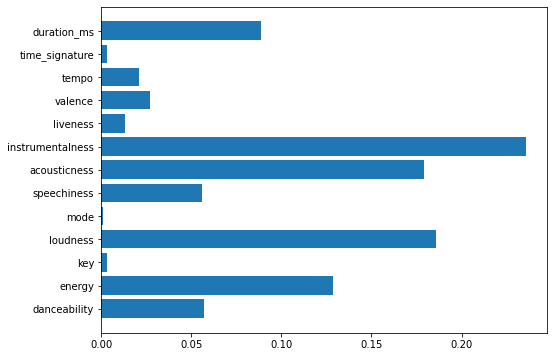

In [17]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_ada.feature_importances_);

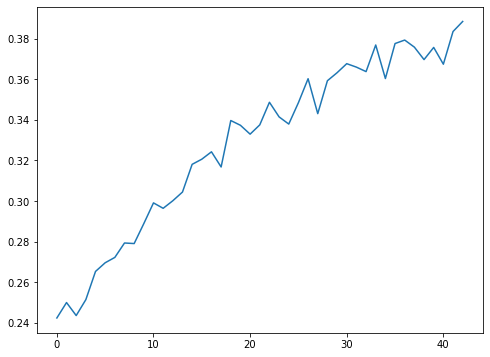

In [18]:
plt.plot(best_ada.estimator_errors_);

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset y vemos los resultados obtenidos

In [19]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=110,
                                                         max_features=4,
                                                         max_leaf_nodes=70,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=4,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                               

In [20]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7654
Precisión sobre el juego de train: 0.7986


In [31]:
filename = '../Models/ada_boost_model_random_93_20.pkl'

In [32]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_model_random_93_20.pkl']

In [23]:
best_ada = joblib.load(filename) 

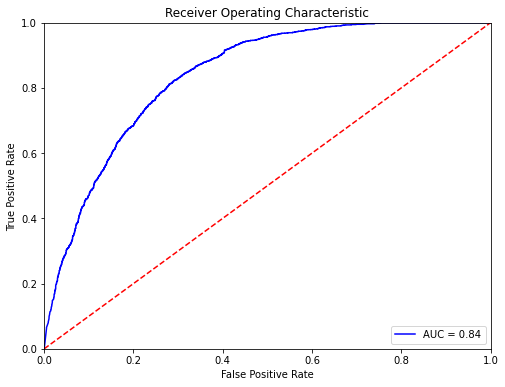

In [24]:
probs = best_ada.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [76]:
score = best_ada.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 46.93950710398086


## Gradient Boosting

- La siguiente tecnica que utilizaremos sera GradientBoosting, y para ello lo haremos usando las dos implementaciones mas usadas de este algoritmo que es lightGBM y XGBoost. Veremos si somos capaces de mejorar nuestra predicción.

### Implementación de lightgbm

- El proceso llevado a cabo es similar a los anterioriores,  para esta implementación a parte de RandomSearch, usaremos también GridSearch para afinar y tratar de conseguir un mejor score.

In [6]:
import lightgbm as lgb

In [8]:
lgb_clf =lgb.LGBMClassifier()

In [9]:
%%time
cross_val_score(lgb_clf, X_train,y_train, cv=5).mean()

Wall time: 1 s


0.7638474266676432

Como se puede apreciar LighGBM es extremadamente rapido en su entrenamiento

In [10]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [11]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7690
Precisión sobre el juego de train: 0.8361


In [12]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [13]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.765476494481433 en train : 0.822722498072024
n_estimators 90 en test: 0.7635215239502304 en train: 0.8429720644449471
n_estimators 100 en test: 0.7638474266676432 en train: 0.8491463425994821
n_estimators 150 en test: 0.7633262540292066 en train: 0.8802619308456345
n_estimators 200 en test: 0.7600677999921459 en train: 0.906148219259282
n_estimators 250 en test: 0.7597421095477206 en train: 0.9284178469871887
n_estimators 300 en test: 0.7585040485765504 en train: 0.9459631271873938


In [14]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [15]:
lgb_clf = lgb.LGBMClassifier(random_state=32)

In [18]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 40000, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [19]:
light_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 19.3min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 22.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=32, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

In [20]:
light_gbm_random.best_params_

{'subsample_for_bin': 120000,
 'reg_lambda': 0.7,
 'reg_alpha': 0.9,
 'num_leaves': 40,
 'n_estimators': 150,
 'min_split_gain': 0.2,
 'min_child_samples': 35,
 'max_depth': 100,
 'learning_rate': 0.1,
 'boosting_type': 'dart'}

In [21]:
light_gbm_random.best_score_

0.7703635068771141

In [22]:
best_light_gbm = light_gbm_random.best_estimator_

In [23]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_light_gbm.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7651
Precisión sobre el juego de train: 0.8104


In [7]:
filename = '../Models/light_gbm_model_random_93_20.pkl'

In [25]:
joblib.dump(best_light_gbm, filename)

['../Models/light_gbm_model_random_93_20.pkl']

In [8]:
best_light_gbm = joblib.load(filename) 

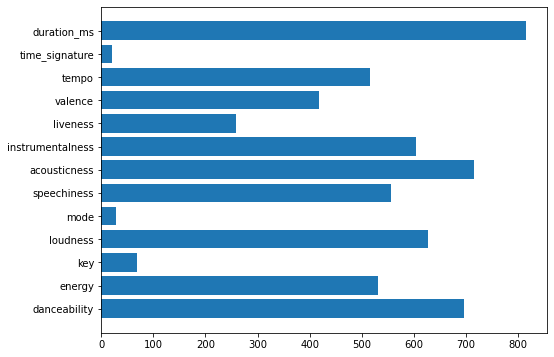

In [9]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_light_gbm.feature_importances_);

In [123]:
best_light_gbm.predict_proba(find_song())

Artista: 

 drake


Titulo: 

Canción elegida: POPSTAR (feat. Drake) de DJ Khaled


array([[0.2944884, 0.7055116]])

### Implementación de xgboost

- Probaremos ahora la implementación de xgboost, lo que sabemos es que ambas implementaciones dan resultados muy similares, pero por contra xgboost es mas lento en el aprendizaje como podremos apreciar a continuación.

In [1]:
import xgboost as xgb

In [4]:
xgb_clf = xgb.XGBClassifier()

In [107]:
%%time
cross_val_score(xgb_clf, X_train,y_train, cv=10).mean()

Wall time: 19.4 s


0.7438599295696648

In [38]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(xgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(xgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7407
Precisión sobre el juego de train: 0.8305


In [40]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                xgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [41]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.7453438732311422 en train : 0.8121290184713172
n_estimators 90 en test: 0.7432204862227548 en train: 0.8382047783748611
n_estimators 100 en test: 0.7426064202777705 en train: 0.8461036187391698
n_estimators 150 en test: 0.7407388335365134 en train: 0.8793491398532345
n_estimators 200 en test: 0.7363129986782256 en train: 0.9057702938495813
n_estimators 250 en test: 0.7359036671981057 en train: 0.9281109267134047
n_estimators 300 en test: 0.7341639085929994 en train: 0.9455523472620386


In [11]:
xgb_clf = xgb.XGBClassifier(learning_rate= 0.1,
                             max_depth=5,
                             min_child_weight=1,
                             gamma=0,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)

In [12]:
xgb_clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(xgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(xgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7442
Precisión sobre el juego de train: 0.7693


In [14]:
booster = ['gbtree', 'gblinear', 'dart']
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(9, 12, num = 4)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Minimum loss reduction required to make a further partition on a leaf node of the tree.
gamma 
# Minimum sum of instance weight(hessian) needed in a child.
min_child_weight = range(5,8)
# Subsample ratio of the training instance.
subsample = [i/10. for i in range(7,11)]
# Subsample ratio of columns when constructing each tree.
colsample_bytree = [i/10. for i in range(7,11)]
# Subsample ratio of columns for each level.
colsample_bylevel 
# Subsample ratio of columns for each split.
colsample_bynode 
# L1 regularization term on weights
reg_alpha 
# L2 regularization term on weights
reg_lambda 
# Balancing of positive and negative weights.
scale_pos_weight 
#The initial prediction score of all instances, global bias.
base_score
# Creacion de cuadrícula aleatoria
param_grid = {'booster': booster,
             'max_depth': max_depth,
             'learning_rate':learning_rate,
             'n_estimators':n_estimators,
             'gamma':gamma,
             'min_child_weight':min_child_weight,
             'subsample':subsample,
             'colsample_bytree':colsample_bytree,
             'colsample_bylevel':colsample_bylevel,
             'colsample_bynode':colsample_bynode,
             'reg_alpha':reg_alpha,
             'reg_lambda':reg_lambda,
             'scale_pos_weight':scale_pos_weight,
             'base_score':base_score}
print(param_grid)

NameError: name 'gamma' is not defined

In [18]:
booster = ['gbtree', 'gblinear', 'dart']
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(9, 12, num = 4)]
max_depth.append(None)
#Learning rate
learning_rate = [float(x) for x in np.linspace(0.005, 1., num = 10)]
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Minimum sum of instance weight(hessian) needed in a child.
min_child_weight = range(5,8)
# Subsample ratio of the training instance.
subsample = [i/10. for i in range(7,11)]
# Subsample ratio of columns when constructing each tree.
colsample_bytree = [i/10. for i in range(7,11)]
# Creacion de cuadrícula aleatoria
param_grid = {'booster': booster,
             'max_depth': max_depth,
             'learning_rate':learning_rate,
             'n_estimators':n_estimators,
             'min_child_weight':min_child_weight,
             'subsample':subsample,
             'colsample_bytree':colsample_bytree}
print(param_grid)

{'booster': ['gbtree', 'gblinear', 'dart'], 'max_depth': [9, 10, 11, 12, None], 'learning_rate': [0.005, 0.11555555555555556, 0.22611111111111112, 0.33666666666666667, 0.44722222222222224, 0.5577777777777778, 0.6683333333333333, 0.778888888888889, 0.8894444444444445, 1.0], 'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'min_child_weight': range(5, 8), 'subsample': [0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.7, 0.8, 0.9, 1.0]}


In [19]:
xgb_clf = xgb.XGBClassifier(random_state=42)

In [20]:
xgb_clf_grid = GridSearchCV(estimator = xgb_clf, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1)

In [21]:
xgb_clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 72000 candidates, totalling 360000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s


KeyboardInterrupt: 

In [24]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_grid, n_iter = 2400, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [ ]:
xgb_random.fit(X_train, y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 40.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 54.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 75.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 101.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 126.5min


## Añadimos año como feature

En un principio no se penso añadir el año como fiature ya que esto limitaria mucho la prediccion en el futuro puesto que todas las nuevas predicciones que se hagan tomaran siempre 2020 como corte, entonces es un feature que impide que el modelo se extrapole en el tiempo, aunque podria dar buenos resultados en fechas actuales e incluso el proximo año ya que la tendencia a corto plazo seran similara a la vivida en el 2020

- Primero definimos una funcion para poder hacer predicciones

In [6]:
def find_song_year():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        get_year = lambda date: parse(date, fuzzy=True).year
        year_realease = get_year(track["album"]["release_date"])
        track_feat = sp.audio_features(id_track)
        song = [[year_realease, track_feat[0]["danceability"], track_feat[0]["energy"],
                 track_feat[0]["key"],track_feat[0]["loudness"], track_feat[0]["mode"],
                 track_feat[0]["speechiness"],track_feat[0]["acousticness"],
                 track_feat[0]["instrumentalness"], track_feat[0]["liveness"],track_feat[0]["valence"],
                 track_feat[0]["tempo"],track_feat[0]["time_signature"],track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Obtenemos el año del dataset para añadirlo como feature

In [7]:
from dateutil.parser import parse

In [8]:
df_songs_year = pd.DataFrame.copy(df_songs)
get_year = lambda date: parse(date, fuzzy=True).year
df_songs_year.insert (12, "year", 0)
for i, item in df_songs_year.iterrows():
    if item['target']==0:
        year = get_year(item['release_date'])
    else:
        year = item['year_chart']
    df_songs_year.loc[i,'year'] = year

In [9]:
X = df_songs_year.loc[:,"year":"duration_ms"]
y = df_songs_year.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Random Forest

In [12]:
forest = RandomForestClassifier ()

In [13]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 12.5 s


0.8116121390430522

In [14]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [15]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8096
Precisión sobre datos de train: 0.9999


In [16]:
param_range = [30,40,50,60,90,100,130,150,200,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [17]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.8037925328731255 en train: 0.999152875569963
n_estimators 40 en test: 0.8113514253600413 en train: 0.99956014384266
n_estimators 50 en test: 0.8106346643911003 en train: 0.999885962972721
n_estimators 60 en test: 0.8129806629922213 en train: 0.9998208004737392
n_estimators 90 en test: 0.8151308397625515 en train: 0.9999348348469574
n_estimators 100 en test: 0.812328857557396 en train: 0.9999511267987332
n_estimators 130 en test: 0.8144792466007136 en train: 0.9999511267987332
n_estimators 150 en test: 0.8148050219543338 en train: 0.9999511267987332
n_estimators 200 en test: 0.8150007164213321 en train: 0.9999511267987332
n_estimators 300 en test: 0.8145447328172978 en train: 0.9999511267987332


In [18]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


In [19]:
forest = RandomForestClassifier (random_state=32)

In [20]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
forest_random.fit(X_train,y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 34.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 42.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 50.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 60.5min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 71.7min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 82.7min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [22]:
forest_random.best_params_

{'n_estimators': 150,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_leaf_nodes': None,
 'max_features': 11,
 'max_depth': 60}

In [23]:
forest_random.best_score_

0.817281462306155

In [24]:
best_forest = forest_random.best_estimator_

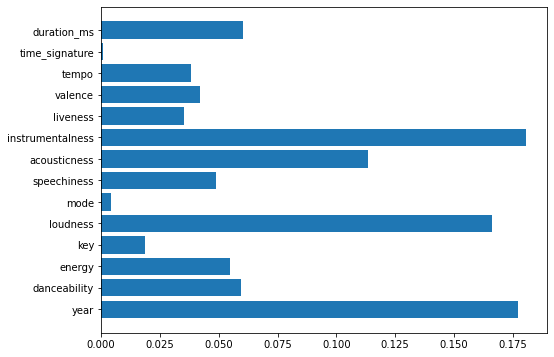

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_forest.feature_importances_);

In [26]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features=11,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [27]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8098
Precisión sobre datos de train: 0.9478


In [10]:
filename = '../Models/forest_model_random_year_93_20.pkl'

In [28]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random_year_93_20.pkl']

## AdaBoost

In [13]:
ada_clf = AdaBoostClassifier()

In [14]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 2.9 s


0.7998824432196292

In [15]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [16]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7891
Precisión sobre el juego de train: 0.8053


In [17]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 10)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [float(x) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}


In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
base_estimator = DecisionTreeClassifier(random_state=32)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=32)

In [20]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 3250, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 3250 candidates, totalling 16250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 17.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 33.1min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 41.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 65.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 79.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 94.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 111.8min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 132.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      |

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

In [22]:
ada_random.best_params_

{'n_estimators': 96,
 'learning_rate': 0.05,
 'base_estimator__min_samples_split': 5,
 'base_estimator__min_samples_leaf': 3,
 'base_estimator__max_leaf_nodes': 80,
 'base_estimator__max_features': 7,
 'base_estimator__max_depth': 30,
 'algorithm': 'SAMME'}

In [23]:
ada_random.best_score_

0.8184544616067155

In [24]:
best_ada = ada_random.best_estimator_

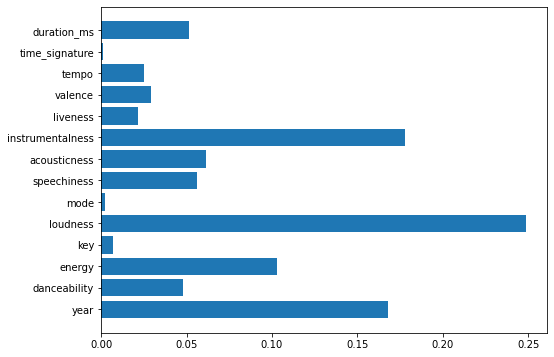

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_ada.feature_importances_);

In [26]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=30,
                                                         max_features=7,
                                                         max_leaf_nodes=80,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=3,
                                                         min_samples_split=5,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                

In [27]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8149
Precisión sobre datos de train: 0.8600


In [16]:
filename = '../Models/ada_boost_random_year_93_20.pkl'

In [17]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_random_year_93_20.pkl']

## LightGBM

In [10]:
import lightgbm as lgb

In [11]:
lgb_clf =lgb.LGBMClassifier()

In [12]:
%%time
cross_val_score(lgb_clf,X_train,y_train,cv=5).mean()

Wall time: 992 ms


0.8170857466118578

In [13]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [14]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8178
Precisión sobre el juego de train: 0.8750


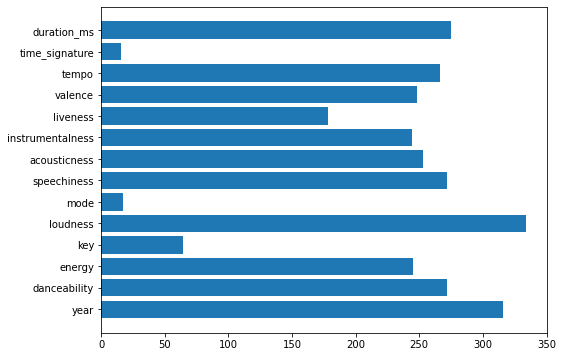

In [15]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, lgb_clf.feature_importances_);

In [16]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [17]:
lgb_clf = lgb.LGBMClassifier(random_state=32)

In [20]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 40000, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [21]:
light_gbm_random.fit(X_train,y_train)

Fitting 5 folds for each of 40000 candidates, totalling 200000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 18.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=32, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

In [22]:
light_gbm_random.best_params_

{'subsample_for_bin': 100000,
 'reg_lambda': 0.6,
 'reg_alpha': 0.8,
 'num_leaves': 50,
 'n_estimators': 60,
 'min_split_gain': 0.8,
 'min_child_samples': 27,
 'max_depth': 80,
 'learning_rate': 0.2,
 'boosting_type': 'dart'}

In [23]:
light_gbm_random.best_score_

0.8208001630256542

In [24]:
best_lgb = light_gbm_random.best_estimator_

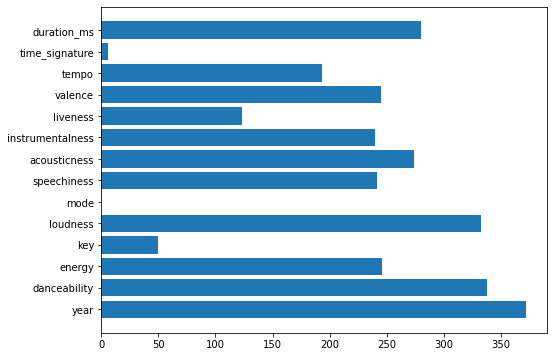

In [25]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_lgb.feature_importances_);

In [26]:
best_lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=80,
               min_child_samples=27, min_child_weight=0.001, min_split_gain=0.8,
               n_estimators=60, n_jobs=-1, num_leaves=50, objective=None,
               random_state=32, reg_alpha=0.8, reg_lambda=0.6, silent=True,
               subsample=1.0, subsample_for_bin=100000, subsample_freq=0)

In [27]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_lgb.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_lgb.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8168
Precisión sobre el juego de train: 0.8671


In [29]:
filename = '../Models/light_gbm_model_random_year_93_20.pkl'

In [30]:
joblib.dump(best_lgb, filename)

['../Models/light_gbm_model_random_year_93_20.pkl']